# Analysis of Demographic Parity and Equalized Odds

This is a notebook I created while reading [Equality of Opportunity in Supervised Learning](https://arxiv.org/abs/1610.02413). 

I am not sure there is a way to access the code the authors used to produce their plots/results, however, after some googling I found the [Fairlearn](https://fairlearn.github.io/v0.5.0/index.html#) package, which seemingly aims to _empowers developers of artificial intelligence (AI) systems to assess their system's fairness and mitigate any observed unfairness issues_. Reading their documentation they seem to implement, among others, the methodology described by the paper above.

I thought it would be good to play around with this tool to assimilate the theoretical concepts introduced by the paper, so what you find below is a minimal overview of the practical use of this methodology, compared to another standard definition of fairness called _Demographic Parity_ (also implemented in Fairlearn)

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [49]:
data_adult = fetch_openml(data_id=1590, as_frame=True)
data_adult.data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States


In [3]:
X = pd.get_dummies(data_adult.data)
y_true = (data_adult.target == '>50K') * 1
sex = data_adult.data['sex']
sex.value_counts()

Male      32650
Female    16192
Name: sex, dtype: int64

In [4]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [5]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
classifier.fit(X, y_true)
y_pred = classifier.predict(X)

### No fairness measure

In [6]:
gm = MetricFrame(accuracy_score, y_true, y_pred, sensitive_features=sex)
print(f"Total accuracy score: {gm.overall}\n")
print(f"Accuracy score by: {gm.by_group}\n")

Total accuracy score: 0.8443552680070431

Accuracy score by: sex
Female    0.925148
Male      0.804288
Name: accuracy_score, dtype: object



### Fairness metrics

When working on fairness, before we can start _fairifying_ models we need to establish fairness metrics to optimise. Here we consider two definitions _Demographic Parity_ and _Equalized Odds_.

* **Demographic Parity**: is defined as `Pr(Y_pred=1 | A=1) = Pr(Y_pred=1 | A=0)`
* **Equalized Odds**: is defined as `Pr(Y_pred=1 | A=1, Y=y) = Pr(Y_pred=1 | A=0, Y=y)`

Since in both cases we won't get perfect equality a good way to assess fairness is to look at the difference between the terms, and this is exactly what is done in `fairnlearn`:

For _Demographic Parity_ we have:
```
demographic_parity_difference = |Pr(Y_pred=1 | A=1) - Pr(Y_pred=1 | A=0)|
```

For _Equalized Odds_ we have:
```
equalized_odds_difference = max(
    |Pr(Y_pred=1 | A=1, Y=0) - Pr(Y_pred=1 | A=0, Y=0)|,
    |Pr(Y_pred=1 | A=1, Y=1) - Pr(Y_pred=1 | A=0, Y=1)|
)
```

In [7]:
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

dp_difference = demographic_parity_difference(y_true, y_pred, sensitive_features=sex)
print(f"Demographic parity difference: {dp_difference}")

eo_difference = equalized_odds_difference(y_true, y_pred, sensitive_features=sex)
print(f"Equalized odds difference: {eo_difference}")

Demographic parity difference: 0.15004887369937472
Equalized odds difference: 0.0811655575720911


### Demographic Parity

In [8]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

mitigator = ExponentiatedGradient(classifier, DemographicParity())
mitigator.fit(X, y_true, sensitive_features=sex)
y_pred_mitigated = mitigator.predict(X)

In [9]:
gm_dp = MetricFrame(accuracy_score, y_true, y_pred_mitigated, sensitive_features=sex)
print(f"Total accuracy score {gm_dp.overall}")
print(gm_dp.by_group)

Total accuracy score 0.8191515498955817
sex
Female    0.891737
Male      0.783155
Name: accuracy_score, dtype: object


In [10]:
dp_difference = demographic_parity_difference(y_true, y_pred_mitigated, sensitive_features=sex)
print(f"Demographic parity difference: {dp_difference}")

Demographic parity difference: 0.015335385784067457


### Equalized Odds

In [21]:
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import EqualizedOdds

mitigator = ThresholdOptimizer(estimator=classifier, constraints='equalized_odds')
mitigator.fit(X, y_true, sensitive_features=sex)
y_pred_mitigated = mitigator.predict(X, sensitive_features=sex)

In [22]:
gm_eo = MetricFrame(accuracy_score, y_true, y_pred_mitigated, sensitive_features=sex)
print(f"Total accuracy score {gm_eo.overall}")
print(gm_eo.by_group)

Total accuracy score 0.8223864706604971
sex
Female    0.881546
Male      0.793047
Name: accuracy_score, dtype: object


In [23]:
eo_to_difference = equalized_odds_difference(y_true, y_pred_mitigated, sensitive_features=sex)
print(f"Equalized odds difference: {eo_to_difference}")

Equalized odds difference: 0.008813252275214123


### Alternative implementation of Equalized Odds

In [24]:
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds

mitigator = ExponentiatedGradient(classifier, EqualizedOdds())
mitigator.fit(X, y_true, sensitive_features=sex)
y_pred_eo_eg = mitigator.predict(X)

In [ ]:
gm_eo_eg = MetricFrame(accuracy_score, y_true, y_pred_eo_eg, sensitive_features=sex)
print(f"Total accuracy score {gm_eo_eg.overall}")
print(gm_eo_eg.by_group)

In [17]:
eo_eg_difference = equalized_odds_difference(y_true, y_pred_eo_eg, sensitive_features=sex)
print(f"Equalized odds difference: {eo_eg_difference}")

Equalized odds difference: 0.01645756164309725


# TODO

### Compare methods to get to equalized odds

In [29]:
# for 4 (datasets, models):
#     for 2-3 methods (plus nothing):
#         calculate eo_difference
#         calculate eo_ratio
#         plot each
        
# plot averages

### Check effectiveness when testing with multiple protected attributes

In [ ]:
# for 4 (datasets, models):
#     for 2-3 methods (plus nothing):
#         calculate eo_difference for each protected feature
#         calculate eo_ratio for each protected feature
#         plot each
        
# plot averages

Datasets:
- student performance (649): http://archive.ics.uci.edu/ml/datasets/Student+Performance
- crime related to zip code? (1994): http://archive.ics.uci.edu/ml/datasets/Communities+and+Crime
- drug consumption (1885): http://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29
- absenteeism (740): http://archive.ics.uci.edu/ml/datasets/Absenteeism+at+work
- bank marketing (45211): http://archive.ics.uci.edu/ml/datasets/Bank+Marketing
- credit default (30000): http://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients
- german credit (1000): http://archive.ics.uci.edu/ml/datasets/South+German+Credit+%28UPDATE%29

In [80]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, EqualizedOdds
from fairlearn.metrics import equalized_odds_difference

### Adult dataset

In [66]:
# Download adult data from https://www.openml.org/d/42477
data_adult = fetch_openml(data_id=1590, as_frame=True)
data_adult.data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States


In [73]:
X_adult = pd.get_dummies(data_adult.data)
y_true_adult = (data_adult.target == '>50K') * 1
sex = data_adult.data['sex']
sex.value_counts()

Male      32650
Female    16192
Name: sex, dtype: int64

In [74]:
classifier_adult = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
classifier.fit(X_adult, y_true_adult)
y_pred_adult = classifier.predict(X_adult)

In [82]:
accuracy_vanilla_pred_adult = MetricFrame(accuracy_score, y_true_adult, y_pred_adult, sensitive_features=sex)
print(f"Total accuracy score: {gm.overall}\n")
print(f"Accuracy score by: {gm.by_group}\n")

eo_difference_vanilla_pred_adult = equalized_odds_difference(y_true_adult, y_pred_adult, sensitive_features=sex)
print(f"Equalized odds difference: {eo_difference_vanilla_pred_adult}")

Total accuracy score: 0.8443552680070431

Accuracy score by: sex
Female    0.925148
Male      0.804288
Name: accuracy_score, dtype: object

Equalized odds difference: 0.0811655575720911


In [90]:
mitigator_eo_to_adult = ThresholdOptimizer(estimator=classifier, constraints='equalized_odds')
mitigator_eo_to_adult.fit(X, y_true, sensitive_features=sex)
y_pred_eo_to_adult = mitigator_eo_to_adult.predict(X, sensitive_features=sex)

accuracy_eo_to_pred_adult = MetricFrame(accuracy_score, y_true, y_pred_eo_to_adult, sensitive_features=sex)
print(f"Total accuracy score {accuracy_eo_to_pred_adult.overall}")
print(accuracy_eo_to_pred_adult.by_group)

eo_difference_to_pred_adult = equalized_odds_difference(y_true, y_pred_eo_to_adult, sensitive_features=sex)
print(f"Equalized odds difference: {eo_difference_to_pred_adult}")

Total accuracy score 0.8217927193808607
sex
Female    0.881979
Male      0.791945
Name: accuracy_score, dtype: object
Equalized odds difference: 0.013856244152873287


In [79]:
mitigator_eo_eg_adult = ExponentiatedGradient(classifier, EqualizedOdds())
mitigator_eo_eg_adult.fit(X, y_true, sensitive_features=sex)
y_pred_eo_eg_adult = mitigator_eo_eg_adult.predict(X)

accuracy_eo_eg_pred_adult = MetricFrame(accuracy_score, y_true, y_pred_eo_eg_adult, sensitive_features=sex)
print(f"Total accuracy score {accuracy_eo_eg_pred_adult.overall}")
print(accuracy_eo_eg_pred_adult.by_group)

eo_difference_eg_pred_adult = equalized_odds_difference(y_true_adult, y_pred_eo_eg_adult, sensitive_features=sex)
print(f"Equalized odds difference: {eo_difference_eg_pred_adult}")

#TODO: add ratio

Total accuracy score 0.8388067646697515
sex
Female    0.895319
Male      0.810781
Name: accuracy_score, dtype: object
Equalized odds difference: 0.01576422461196643


(0.75, 0.9)

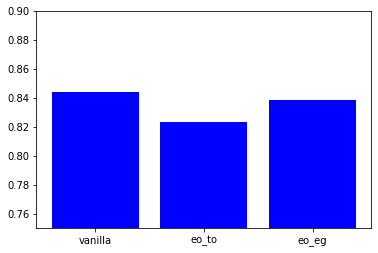

In [87]:
x = ['vanilla', 'eo_to', 'eo_eg']
y = [
    accuracy_vanilla_pred_adult.overall, 
    accuracy_eo_to_pred_adult.overall, 
    accuracy_eo_eg_pred_adult.overall,
]
plt.bar(x, y, color = 'b', label='Accuracy')
plt.ylim([0.75, 0.9])

([<matplotlib.axis.XTick at 0x129a0baf0>,
 [Text(1.25, 0, '$vanilla$'),
  Text(2.25, 0, '$eo_to$'),
  Text(3.25, 0, '$eo_eg$')])

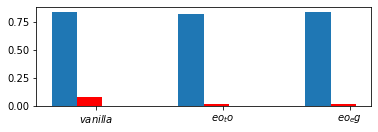

In [94]:
x = ['vanilla', 'eo_to', 'eo_eg']
accuracy = [
    accuracy_vanilla_pred_adult.overall, 
    accuracy_eo_to_pred_adult.overall, 
    accuracy_eo_eg_pred_adult.overall,
]
eo_difference = [
    eo_difference_vanilla_pred_adult, 
    eo_difference_to_pred_adult, 
    eo_difference_eg_pred_adult,
]

width = 0.2
locs = np.arange(1, len(x)+1)
plt.subplot(2,1,2)
plt.bar(locs, accuracy, width=width, label='Accuracy')
plt.bar(locs+width, eo_difference, width=width, color="red", label='y')
# plt.bar(locs+2*width, z, width=width, color="black", label='z')
# plt.legend()

plt.xticks([1.25, 2.25, 3.25],
          [r'$vanilla$', r'$eo_to$', r'$eo_eg$'])

### Credit default dataset

In [54]:
# Download credit default data from https://www.openml.org/d/42477
data_credit_default = fetch_openml(data_id=42477, as_frame=True)
data_credit_default.data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23
0,20000.0,2.0,2.0,1.0,24.0,2.0,2.0,-1.0,-1.0,-2.0,...,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0
1,120000.0,2.0,2.0,2.0,26.0,-1.0,2.0,0.0,0.0,0.0,...,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0
2,90000.0,2.0,2.0,2.0,34.0,0.0,0.0,0.0,0.0,0.0,...,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
3,50000.0,2.0,2.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,...,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
4,50000.0,1.0,2.0,1.0,57.0,-1.0,0.0,-1.0,0.0,0.0,...,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0


In [55]:
X_credit_default = pd.get_dummies(data_credit_default.data)
y_true_credit_default = (data_credit_default.target == '>50K') * 1
sex = data_credit_default.data['x2']
sex.value_counts()

2.0    18112
1.0    11888
Name: x2, dtype: int64

In [71]:
data_credit_default.target

0        1
1        1
2        0
3        0
4        0
        ..
29995    0
29996    0
29997    1
29998    1
29999    1
Name: y, Length: 30000, dtype: category
Categories (2, object): ['0', '1']

### Bank marketing dataset

In [56]:
#Download bank marketing data from https://www.openml.org/d/1461
data_bank_marketing = fetch_openml(data_id=1461, as_frame=True)
data_bank_marketing.data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16
0,58.0,management,married,tertiary,no,2143.0,yes,no,unknown,5.0,may,261.0,1.0,-1.0,0.0,unknown
1,44.0,technician,single,secondary,no,29.0,yes,no,unknown,5.0,may,151.0,1.0,-1.0,0.0,unknown
2,33.0,entrepreneur,married,secondary,no,2.0,yes,yes,unknown,5.0,may,76.0,1.0,-1.0,0.0,unknown
3,47.0,blue-collar,married,unknown,no,1506.0,yes,no,unknown,5.0,may,92.0,1.0,-1.0,0.0,unknown
4,33.0,unknown,single,unknown,no,1.0,no,no,unknown,5.0,may,198.0,1.0,-1.0,0.0,unknown


In [58]:
X_bank_marketing = pd.get_dummies(data_bank_marketing.data)
y_true_bank_marketing = (data_bank_marketing.target == '>50K') * 1
sex = data_bank_marketing.data['V3']
sex.value_counts()

married     27214
single      12790
divorced     5207
Name: V3, dtype: int64

### Data student performance

In [61]:
#Download student performance data from https://www.openml.org/d/42565
data_student_performance = fetch_openml(data_id=42565, as_frame=True)
data_student_performance.data.head()

,attribute_0,avg_marks,min_marks,max_marks,surrounding_environment,level_of_comfortable_zone_for_student,university_contribution_in_paper_setting,stud_contribution_in_fighting_for_exam,stud_teacher_contribution_in_learning,gender,...,inappropriate_yllabus,family_responsiblities,festival_holidays,financial_status,incentive_programs,exam_stress,overall_pg_performance,pg_sem_4_10_classes,pg_class_coded,pg_class_coded_cat
0,0.0,68.166667,42.500000,54.500000,3.0,9.0,5.0,4.0,5.0,1.0,...,2.0,2.0,1.0,2.0,1.0,1.0,1.0,6.0,6.0,2
1,1.0,68.214286,42.535714,54.535714,3.0,9.0,5.0,4.0,5.0,1.0,...,2.0,2.0,1.0,2.0,1.0,1.0,1.0,6.0,6.0,2
2,2.0,74.966667,47.600000,59.600000,3.0,9.0,5.0,4.0,5.0,1.0,...,2.0,2.0,1.0,2.0,1.0,1.0,1.0,7.0,7.0,3
3,3.0,75.500000,48.000000,60.000000,3.0,9.0,5.0,4.0,5.0,1.0,...,2.0,2.0,1.0,2.0,1.0,1.0,1.0,7.0,7.0,3
4,4.0,76.166667,48.500000,60.500000,3.0,9.0,5.0,4.0,5.0,1.0,...,2.0,2.0,1.0,2.0,1.0,1.0,1.0,7.0,7.0,3


In [63]:
X_student_performance = pd.get_dummies(data_student_performance.data)
y_true_student_performance = (data_student_performance.target == '>50K') * 1
sex = data_student_performance.data['gender']
sex.value_counts()

2.0    2021
1.0    1871
Name: gender, dtype: int64

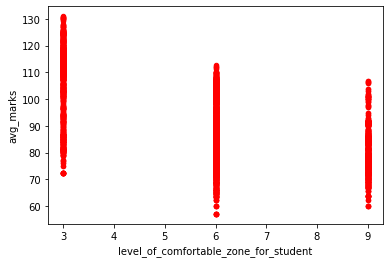

In [48]:
data_student_performance.data.plot(kind='scatter',x='level_of_comfortable_zone_for_student',y='avg_marks',color='red')
plt.show()